<a href="https://colab.research.google.com/github/shreyab375/Natural-Language-Processing/blob/main/Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

Credit card / Prepaid card

Bank account services

Theft/Dispute reporting

Mortgages/loans

Others

With the help of topic modelling, we will be able to map each ticket onto its respective department/category. we can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

In [17]:
#importing the librabies
import json
import pandas as pd
import numpy as np
import nltk, spacy,string
import en_core_web_sm
model = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
import re
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Opening JSON file
f = open('/content/complaints-2021-05-14_08_16.json')

data = json.load(f)
df=pd.json_normalize(data)

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
df = df[['_source.complaint_what_happened', '_source.product']]

In [11]:
df.head()

,_source.complaint_what_happened,_source.product
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


In [12]:
df = df[df['_source.complaint_what_happened'].astype(bool)]
df.head()

,_source.complaint_what_happened,_source.product
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


In [13]:
# Function to clean the text and remove all the unnecessary elements.
def prepare(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text


In [18]:
# Preparing the data

df['complaints'] = df['_source.complaint_what_happened'].apply(prepare)
df.head()

,_source.complaint_what_happened,_source.product,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,my grand son give me check for i deposit it in...


In [19]:
# Function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [22]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemmatization)})

In [23]:
#Write your function to extract the POS tags

def get_pos_tags(text):
    nn_words = []
    doc = model(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

In [24]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...


In [29]:
doc_len = [len(d) for d in df_clean.complaint_POS_removed]

(0.0, 5000.0)

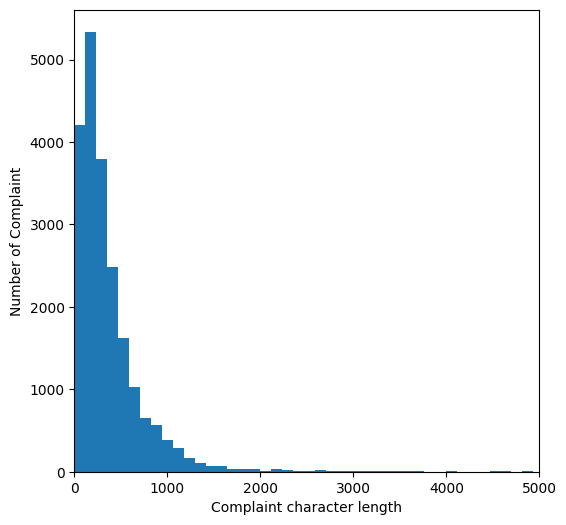

In [38]:
plt.figure(figsize=(6,6))
plt.hist(doc_len, bins=100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.xlim(0,5000)

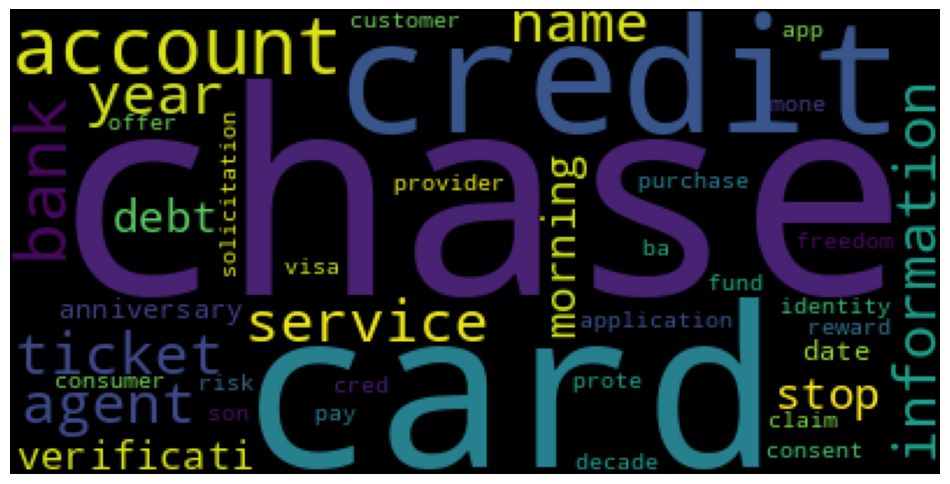

In [40]:
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [42]:
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram


In [43]:
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


In [44]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [46]:
#Feature extraction
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

,0n,10min,1692section,18th,1st,22nd,23rd,2from,2nd,30yr,...,zeal,zelle,zi,zilch,zip,zipcode,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
from sklearn.decomposition import NMF

In [48]:
#Topic Modelling

N_TOPICS = 5
nmf = NMF(random_state = 50, n_components=N_TOPICS)
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

In [52]:
# Top 15 words per topic

words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,fee,checking,business,number,transaction,customer
Topic 2,card,credit,chase,balance,account,fee,limit,score,year,month,purchase,point,offer,service,time
Topic 3,payment,loan,mortgage,chase,month,home,modification,time,year,rate,balance,property,fee,statement,day
Topic 4,inquiry,report,credit,company,bureau,information,reporting,debt,identity,score,theft,account,letter,application,creditor
Topic 5,charge,chase,transaction,dispute,claim,fraud,merchant,letter,email,service,information,phone,time,purchase,day


In [54]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf.transform(X)
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 4, 1, 2])

In [55]:
df_clean['Topic'] = topic_results.argmax(axis=1)

In [56]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [57]:
# Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
24,mishandling of this account by chase auto and,mishandling of this account by chase auto and,account chase auto,account chase auto,0
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on and use...,i opened an account with chase bank on and use...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount ch...,chase catering order brother funeral amount ch...,1
50,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


In [58]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

In [59]:
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [60]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints', 'Topic'	]]

In [61]:
training_data.head()

,complaints,Topic
1,good morning my name is and i appreciate it if...,Account Services
2,i upgraded my card in and was told by the agen...,Others
10,chase card was reported on however fraudulent ...,Others
11,on while trying to book a ticket i came across...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,Account Services


In [62]:
#Supervised Learnings
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [65]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [66]:
#Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

                             precision    recall  f1-score   support

           Account Services       0.93      0.93      0.93      1043
Credit card or prepaid card       0.94      0.86      0.90       417
              Mortgage/Loan       0.93      0.96      0.94      1000
                     Others       0.93      0.91      0.92       841
    Theft/Dispute Reporting       0.88      0.90      0.89       914

                   accuracy                           0.92      4215
                  macro avg       0.92      0.91      0.91      4215
               weighted avg       0.92      0.92      0.92      4215



In [67]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

                             precision    recall  f1-score   support

           Account Services       0.78      0.78      0.78      1043
Credit card or prepaid card       0.75      0.74      0.74       417
              Mortgage/Loan       0.83      0.82      0.83      1000
                     Others       0.77      0.78      0.77       841
    Theft/Dispute Reporting       0.69      0.70      0.70       914

                   accuracy                           0.77      4215
                  macro avg       0.76      0.76      0.76      4215
               weighted avg       0.77      0.77      0.77      4215



In [68]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

                             precision    recall  f1-score   support

           Account Services       0.65      0.92      0.76      1043
Credit card or prepaid card       0.99      0.20      0.33       417
              Mortgage/Loan       0.71      0.94      0.81      1000
                     Others       0.81      0.57      0.66       841
    Theft/Dispute Reporting       0.79      0.65      0.71       914

                   accuracy                           0.72      4215
                  macro avg       0.79      0.66      0.66      4215
               weighted avg       0.76      0.72      0.70      4215



In [69]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

                             precision    recall  f1-score   support

           Account Services       0.40      0.29      0.34      1043
Credit card or prepaid card       0.29      0.64      0.40       417
              Mortgage/Loan       0.52      0.41      0.46      1000
                     Others       0.30      0.39      0.34       841
    Theft/Dispute Reporting       0.40      0.28      0.33       914

                   accuracy                           0.37      4215
                  macro avg       0.38      0.40      0.37      4215
               weighted avg       0.40      0.37      0.37      4215

